In [1726]:
%pylab inline
import time
from multiprocessing import Pool
from sklearn.datasets import make_blobs, make_classification, make_moons
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score
import scipy
import numpy as np
import cvxopt

Populating the interactive namespace from numpy and matplotlib


/Users/Artem/anaconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [1727]:
class SVMSolver:
    """
    Класс с реализацией SVM через метод внутренней точки.
    """

    def __init__(self, C=1, method='primal', kernel='linear', degree=1, gamma=1):
        """
        C - float, коэффициент регуляризации

        method - строка, задающая решаемую задачу, может принимать значения:
            'primal' - соответствует прямой задаче
            'dual' - соответствует двойственной задаче
        kernel - строка, задающая ядро при решении двойственной задачи
            'linear' - линейное
            'polynomial' - полиномиальное
            'rbf' - rbf-ядро
        Обратите внимание, что часть функций класса используется при одном методе решения,
        а часть при другом
        """
        self.C = C
        self.method = method
        self.kernel = kernel
        self.degree = degree
        self.gamma = gamma
        self.dual = None
        self.ksi = None
        self.w0 = None
        self.w = None

    def get_params(self, deep=False):
        return {'C':self.C, 'method':self.method, 'kernel':self.kernel, 'degree':self.degree, 'gamma':self.gamma}
    
    def set_params(self, **kwargs):
        self.__dict__.update(kwargs)
        #print(self.get_params())
        return self
        

    def K(self, X, Y):
        if self.kernel == 'linear':
            return X.dot(Y.T)
        elif self.kernel == 'polynomial':
            return (1 + X.dot(Y.T)) ** self.degree
        elif self.kernel == 'rbf':
            return np.exp(-self.gamma * ((X ** 2).sum(axis=1)[:, np.newaxis] + (Y.T ** 2).sum(axis=0)[np.newaxis, :]
                                         - 2 * X.dot(Y.T)))
        else:
            raise TypeError('Unknown kernel type')

    def compute_primal_objective(self, X, y):
        """
        Метод для подсчета целевой функции SVM для прямой задачи

        X - переменная типа numpy.array, признаковые описания объектов из обучающей выборки
        y - переменная типа numpy.array, правильные ответы на обучающей выборке,
        """
        if self.method == 'dual':
            raise TypeError('Cannot compute primal oblective for dual method')
        #print('computing')
        M = 1 - y.reshape(X.shape[0], 1) * X.dot(self.w)
        ksi = np.where(M > 0, M, 0).sum()
        return ksi * (self.C / X.shape[0]) + (1 / 2) * (self.w ** 2).sum()

    def compute_dual_objective(self, X, y):
        """
        Метод для подсчёта целевой функции SVM для двойственной задачи

        X - переменная типа numpy.array, признаковые описания объектов из обучающей выборки
        y - переменная типа numpy.array, правильные ответы на обучающей выборке,
        """
        if self.method == 'primal':
            raise TypeError('Cannot compute dual oblective for primal method')
        if self.dual is None:
            raise TypeError("Function has not been optimized yet")
        return -self.dual.sum() + (1 / 2) * (np.outer(self.sv_y, self.sv_y)
                                             * self.K(self.sv, self.sv)).dot(self.dual).dot(self.dual)

    def fit(self, X, y, tolerance=1e-8, max_iter=100):
        """
        Метод для обучения svm согласно выбранной в method задаче

        X - переменная типа numpy.array, признаковые описания объектов из обучающей выборки
        y - переменная типа numpy.array, правильные ответы на обучающей выборке,
        tolerance - требуемая точность для метода обучения
        max_iter - максимальное число итераций в методе

        """
        y = y.reshape(X.shape[0])
        opts = {'reltol': tolerance, 'maxiters': max_iter, 'show_progress': False}
        if self.method == 'primal':
            Y = np.tile(y, (X.shape[1] + 1, 1)).T
            G = np.hstack((np.ones((X.shape[0], 1)), X)) * (-Y)
            G = np.hstack((G, -np.identity(X.shape[0])))
            G = cvxopt.matrix(np.vstack((G, np.hstack(
                (np.zeros((X.shape[0], X.shape[1] + 1)), -np.identity(X.shape[0]))))))
            P = np.vstack(
                (np.eye(X.shape[1]), np.zeros((X.shape[0], X.shape[1]))))
            P = np.hstack((P, np.zeros((X.shape[0] + X.shape[1], X.shape[0]))))
            P = np.vstack((np.zeros((1, X.shape[1] + X.shape[0])), P))
            P = cvxopt.matrix(
                np.hstack((np.zeros((X.shape[0] + X.shape[1] + 1, 1)), P)))
            q = cvxopt.matrix(np.vstack(
                (np.zeros((X.shape[1] + 1, 1)), (self.C / X.shape[0]) * np.ones((X.shape[0], 1)))))
            h = cvxopt.matrix(
                np.vstack((-np.ones((X.shape[0], 1)), np.zeros((X.shape[0], 1)))))
            solution = cvxopt.solvers.qp(P, q, G, h, options=opts)
            self.w0 = solution['x'][0]
            self.w = np.array(solution['x'][1:X.shape[1] + 1])
        elif self.method == 'dual':
            P = cvxopt.matrix(self.K(X, X) * np.outer(y, y))
            q = cvxopt.matrix(-np.ones((X.shape[0], 1)))
            G = cvxopt.matrix(
                np.vstack((np.identity(X.shape[0]), -np.identity(X.shape[0]))))
            h = cvxopt.matrix(np.vstack(
                ((self.C / X.shape[0]) * np.ones((X.shape[0], 1)), np.zeros((X.shape[0], 1)))))
            A = cvxopt.matrix(y.reshape((1, y.shape[0])).astype(float))
            b = cvxopt.matrix([0.0])
            solution = cvxopt.solvers.qp(P, q, G, h, A, b, options=opts)
            lambda_1 = np.ravel(solution['x'])
            self.dual = lambda_1[lambda_1 > 1e-8]
            self.sv = X[lambda_1 > 1e-8]
            self.sv_y = y[lambda_1 > 1e-8]
            if self.kernel == 'linear':
                self.w = ((self.sv_y * self.dual)
                          [:, np.newaxis] * self.sv).sum(axis=0)
            ind = self.dual + 1e-8 < self.C / X.shape[0]
            if (ind.sum() == 0):
                self.w0 = 0
            else:
                self.w0 = (1 / ind.sum()) * (-self.K(self.sv, self.sv)
                                             [ind].dot(self.sv_y * self.dual) + self.sv_y[ind]).sum()
        else:
            raise TypeError('Unknown method')
        return self

    def predict(self, X):
        """
        Метод для получения предсказаний на данных

        X - переменная типа numpy.array, признаковые описания объектов из обучающей выборки
        """
        if self.w is None:
            if self.method == 'dual' and self.kernel != 'linear':
                #print(self.dual, self.K(X, self.sv), self.sv_y, self.w0)
                return np.sign((self.K(X, self.sv) * (self.dual * self.sv_y)).sum(axis=1) + self.w0)
            raise TypeError('Weights have not been computed yet')
        else:
            return np.sign(X.dot(self.w) + self.w0)

    def get_w(self, X=None, y=None):
        """
        Получить прямые переменные (без учёта w_0)

        Если method = 'dual', а ядро линейное, переменные должны быть получены
        с помощью выборки (X, y) 

        return: одномерный numpy array
        """
        if self.w is None:
            if self.method == 'dual' and self.kernel != 'linear':
                raise TypeError(
                    'Cannot return weights when method is dual and kernel is not linear')
            else:
                raise TypeError('Weights have not been computed yet')
        else:
            return self.w

    def get_w0(self, X=None, y=None):
        """
        Получить вектор сдвига

        Если method = 'dual', а ядро линейное, переменные должны быть получены
        с помощью выборки (X, y) 

        return: float
        """
        if self.w0 is None:
            raise TypeError('w0 has not been computed yet')
        else:
            return self.w0

    def get_dual(self):
        """
        Получить двойственные переменные

        return: одномерный numpy array
        """
        if self.method == 'primal':
            raise TypeError(
                'Dual variables are unavailiable when method is "primal"')
        if self.dual is None:
            raise TypeError('Dual variables have not been computed yet')
        else:
            return self.dual

In [1728]:
X1 = np.random.multivariate_normal(mean = 2 * np.ones(20), cov = np.eye(20), size=1000)
X2 = np.random.multivariate_normal(mean = -2 * np.ones(20), cov = np.eye(20), size=1000)
X_gs_ls = np.vstack((X1, X2))
y_gs_ls = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0])))).reshape(X_ls.shape[0])

In [1729]:
X_gs_ls = cl_st.fit_transform(X_gs_ls)
X_gs_ls_train, X_gs_ls_test, y_gs_ls_train, y_gs_ls_test = train_test_split(X_gs_ls, y_gs_ls, train_size=0.7)


cl_test = SVMSolver(C=10, method='dual', kernel='polynomial', degree=8)
cl_test.fit(X_gs_ls_train, y_gs_ls_train)

y_score = cl_test.predict(X_gs_ls_test)
print(cl_test.compute_dual_objective(X_gs_ls_train, y_gs_ls_train), (y_score==y_gs_ls_test).mean())

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.0 0.0


In [1730]:
cl_st = StandardScaler()
X, y = make_blobs(n_samples=300, centers=[[1.0, 5.0], [4.0, 7.0]], cluster_std=0.8, random_state=1234)
y[y == 0] = -1

In [1731]:
class GDClassifier:
    """
    Реализация метода градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(self, loss='hinge', step_alpha=1, step_beta=0,
                 tolerance=1e-5, max_iter=1000, C=1):
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.loss = loss
        self.C = C
        self.history = {}
        self.w = None

    def fit(self, X, y, w_0=None, trace=True, accuracy=False):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w_0 - начальное приближение в методе

        trace - переменная типа bool

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)

        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        y = y.reshape(X.shape[0])
        
        if self.loss == 'logistic':
            self.cl = BinaryLogistic(self.C)
        else:
            self.cl = BinaryHinge(self.C)

        if w_0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = w_0

        if accuracy is True:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, train_size=0.7, random_state=11)
            self.history['accuracy'] = [
                (self.predict(X_test) == y_test).sum() / y_test.shape[0]]
        else:
            X_train, y_train = X, y

        if trace is True:
            self.history['time'] = [0]
            self.history['func'] = [self.get_objective(X_train, y_train)]

        f_min = self.get_objective(X_train, y_train)
        self.w_min = self.w.copy()

        for i in range(self.max_iter):
            start = time.time()
            prev_f = self.get_objective(X_train, y_train)
            self.w = self.w - (self.step_alpha / ((i + 1) **
                                                  (self.step_beta))) * self.get_gradient(X_train, y_train)
            cur_f = self.get_objective(X_train, y_train)
            if cur_f < f_min:
                f_min = cur_f
                self.w_min = self.w.copy()
            if accuracy is True:
                self.history['accuracy'].append(
                    (self.predict(X_test) == y_test).sum() / y_test.shape[0])
            if trace is True:
                self.history['func'].append(cur_f)
                self.history['time'].append(
                    time.time() - start + self.history['time'][-1])
            if abs(prev_f - cur_f) < self.tolerance:
                print('converged')
                break
        if trace is True:
            self.history['sol'] = (f_min, self.w_min)
        return self.history if (trace is True) else (f_min, self.w_min)

    def get_params(self, deep=False):
        return {'step_alpha':self.step_alpha, 'step_beta':self.step_beta,\
                'max_iter':self.max_iter, 'tolerance':self.tolerance, 'C':self.C}
    
    def set_params(self, **params):
        self.__dict__.update(params)
        #print(self.get_params())
        return self
    
    def predict(self, X):
        """
        Получение меток ответов на выборке X

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        return: одномерный numpy array с предсказаниями
        """
        if self.w is None:
            raise TypeError('Weights have not been computed yet')
        return np.sign(X.dot(self.w_min)).reshape(X.shape[0])

    def get_objective(self, X, y):
        """
        Получение значения целевой функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: float
        """
        return self.cl.func(X, y, self.w)

    def get_gradient(self, X, y):
        """
        Получение значения градиента функции на выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        y - одномерный numpy array

        return: numpy array, размерность зависит от задачи
        """
        return self.cl.grad(X, y, self.w)

    def get_weights(self):
        """
        Получение значения весов функционала
        """
        return self.w_min


class SGDClassifier(GDClassifier):
    """
    Реализация метода стохастического градиентного спуска для произвольного
    оракула, соответствующего спецификации оракулов из модуля oracles.py
    """

    def __init__(self, loss='hinge', batch_size=1, step_alpha=1, step_beta=0,
                 tolerance=1e-5, max_iter=1000, random_seed=153, C=1):
        self.batch_size = batch_size
        self.step_alpha = step_alpha
        self.step_beta = step_beta
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.C = C
        self.loss = loss
        self.history = {}
        self.seed = random_seed
        self.w = None

    def get_params(self, deep=False):
        return {'step_alpha':self.step_alpha, 'step_beta':self.step_beta, 
                'max_iter':self.max_iter, 'tolerance':self.tolerance, 'C':self.C,
               'random_seed':self.seed, 'batch_size':self.batch_size}
    
    def fit(self, X, y, w_0=None, trace=True, log_freq=1, accuracy=False):
        y = y.reshape(X.shape[0])
        
        np.random.seed(self.seed)

        if self.loss == 'logistic':
            self.cl = BinaryLogistic(self.C)
        else:
            self.cl = BinaryHinge(self.C)

        if w_0 is None:
            self.w = np.zeros(X.shape[1])
        else:
            self.w = w_0

        if accuracy is True:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, train_size=0.7, random_state=11)
            self.history['accuracy'] = [
                (self.predict(X_test) == y_test).sum() / y_test.shape[0]]
        else:
            X_train, y_train = X, y

        self.history['func'] = [self.get_objective(X_train, y_train)]
        self.history['epoch'] = [0]

        if trace is True:
            self.history['time'] = [0]
            self.history['weights_diff'] = [0]

        curr_ep = 0
        coefs = np.random.choice(
            range(X_train.shape[0]), self.max_iter * self.batch_size)
        f_min = self.get_objective(X_train, y_train)
        self.w_min = self.w.copy()

        for i in range(self.max_iter):
            start = time.time()
            self.w = self.w - (self.step_alpha / ((i + 1) ** (self.step_beta))) *\
                self.get_gradient(X_train[coefs[i * self.batch_size:(i + 1) * self.batch_size:]],
                                  y_train[coefs[i * self.batch_size:(i + 1) * self.batch_size:]])
            curr_ep = self.batch_size * (i + 1) / X.shape[0]
            if (curr_ep - self.history['epoch'][-1] >= log_freq):
                cur_f = self.get_objective(X_train, y_train)
                if cur_f < f_min:
                    f_min = cur_f
                    self.w_min = self.w.copy()
                self.history['func'].append(cur_f)
                self.history['epoch'].append(curr_ep)
                if accuracy is True:
                    self.history['accuracy'].append(
                        (self.predict(X_test) == y_test).sum() / y_test.shape[0])
                if trace is True:
                    self.history['time'].append(
                        time.time() - start + self.history['time'][-1])
                if abs(self.history['func'][-2] - self.history['func'][-1]) < self.tolerance:
                    print('converged')
                    break
        if trace is True:
            self.history['sol'] = (f_min, self.w_min)
        return self.history if (trace is True) else (f_min, self.w_min)

In [1732]:
class PEGASOSMethod:
    """
    Реализация метода Pegasos для решения задачи svm.
    """

    def __init__(self, step_lambda, batch_size, num_iter, random_seed=None):
        """
        step_lambda - величина шага, соответствует 

        batch_size - размер батча

        num_iter - число итераций метода, предлагается делать константное
        число итераций 
        """
        self.batch_size = batch_size
        self.step_lambda = step_lambda
        self.num_iter = num_iter
        self.seed = random_seed
        self.w = None
        self.history = {}
        
    def get_params(self, deep=False):
        return {'step_lambda':self.step_lambda, 'num_iter':self.num_iter,
               'random_seed':self.seed, 'batch_size':self.batch_size}
    
    def set_params(self, **params):
        self.__dict__.update(params)
        return self

    def fit(self, X, y, trace=True, accuracy=False, log_freq=0.01):
        """
        Обучение метода по выборке X с ответами y

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        trace - переменная типа bool

        Если trace = True, то метод должен вернуть словарь history, содержащий информацию 
        о поведении метода. Длина словаря history = количество итераций + 1 (начальное приближение)

        history['time']: list of floats, содержит интервалы времени между двумя итерациями метода
        history['func']: list of floats, содержит значения функции на каждой итерации
        (0 для самой первой точки)
        """
        y = y.reshape(X.shape[0])
        
        if self.seed is None:
            self.seed = np.random.randint(0, 1000, size=1)[0]
        np.random.seed(self.seed)

        self.w = np.zeros((X.shape[1]))

        if accuracy is True:
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, train_size=0.7, random_state=11)
            self.history['accuracy'] = [
                (self.predict(X_test) == y_test).sum() / y_test.shape[0]]
        else:
            X_train, y_train = X, y

        self.history['func'] = [self.get_objective(X_train, y_train)]
        self.history['epoch'] = [0]

        if trace is True:
            self.history['time'] = [0]

        f_min = self.get_objective(X_train, y_train)
        self.w_min = self.w.copy()

        curr_ep = 0
        coefs = np.random.choice(
            range(X_train.shape[0]), self.num_iter * self.batch_size)

        for i in range(self.num_iter):
            start = time.time()
            self.w = (1 - (1 / (i + 1))) * self.w + (1 / self.batch_size * (i + 1) * self.step_lambda) *\
                self.get_gradient(X_train[coefs[i * self.batch_size:(i + 1) * self.batch_size:]],
                                  y_train[coefs[i * self.batch_size:(i + 1) * self.batch_size:]])
            curr_ep = self.batch_size * (i + 1) / X.shape[0]
            if 1 / ((self.step_lambda ** (0.5)) * np.linalg.norm(self.w)) < 1:
                self.w *= 1 / ((self.step_lambda ** (0.5))
                               * np.linalg.norm(self.w))
            if (curr_ep - self.history['epoch'][-1] >= log_freq):
                cur_f = self.get_objective(X_train, y_train)
                if cur_f < f_min:
                    f_min = cur_f
                    self.w_min = self.w.copy()
                self.history['func'].append(cur_f)
                self.history['epoch'].append(curr_ep)
                if accuracy is True:
                    self.history['accuracy'].append(
                        (self.predict(X_test) == y_test).sum() / y_test.shape[0])
                if trace is True:
                    self.history['time'].append(
                        time.time() - start + self.history['time'][-1])
        if trace is True:
            self.history['sol'] = (f_min, self.w_min)
        return self.history if (trace is True) else (f_min, self.w_min)

    def get_objective(self, X, y):
        M = 1 - y * X.dot(self.w.T)
        return (self.step_lambda / 2) * (self.w ** 2).sum() + (1 / X.shape[0]) * np.where(M > 0, M, 0).sum()

    def get_gradient(self, X, y):
        M = y * X.dot(self.w.T)
        return (np.where(M < 1, 1, 0)[:, np.newaxis] * y[:, np.newaxis] * X).sum(axis=0)

    def predict(self, X):
        """
        Получить предсказания по выборке X

        X - scipy.sparse.csr_matrix или двумерный numpy.array
        """
        if self.w is None:
            raise TypeError('Weights have not been computed yet')
        return np.sign(X.dot(self.w_min))

In [1733]:
import numpy as np
import scipy


class BaseSmoothOracle:
    """
    Базовый класс для реализации оракулов.
    """

    def func(self, w):
        """
        Вычислить значение функции в точке w.
        """
        raise NotImplementedError('Func oracle is not implemented.')

    def grad(self, w):
        """
        Вычислить значение градиента функции в точке w.
        """
        raise NotImplementedError('Grad oracle is not implemented.')


class BinaryHinge(BaseSmoothOracle):
    """
    Оракул для задачи двухклассового линейного SVM.
    """

    def __init__(self, C=1):
        """
        Задание параметров оракула.
        """
        self.C = C

    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        M = 1 - y * X.dot(w.T)
        return (1 / 2) * (np.linalg.norm(w[1::]) ** 2) + (self.C) * np.where(M > 0, M, 0).mean()

    def grad(self, X, y, w):
        """
        Вычислить субградиент функционала в точке w на выборке X с ответами y.
        Субгрдиент в точке 0 необходимо зафиксировать равным 0.

        X - scipy.sparse.csr_matrix или двумерный numpy.array

        y - одномерный numpy array

        w - одномерный numpy array
        """
        w_ = np.append(0, w[1::])
        M = 1 - y * X.dot(w.T)
        return w_ - (self.C / X.shape[0]) * (np.where(M >= 0, 1, 0)[:, np.newaxis] * (y[:, np.newaxis] * X)).sum(axis=0)
    
    
class BinaryLogistic(BaseSmoothOracle):
    """
    Оракул для задачи двухклассовой логистической регрессии.
    
    Оракул должен поддерживать l2 регуляризацию.
    """
    
    def __init__(self, C=0.001):
        """
        Задание параметров оракула.
        
        l2_coef - коэффициент l2 регуляризации
        """
        self.lambda_2 = C
     
    def func(self, X, y, w):
        """
        Вычислить значение функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        return (1 / X.shape[0]) * (np.logaddexp(0, (-1) * y * X.dot(w)).sum(axis=0))\
            + (self.lambda_2 / 2) * (w ** 2).sum()
        
    def grad(self, X, y, w):
        """
        Вычислить градиент функционала в точке w на выборке X с ответами y.
        
        X - scipy.sparse.csr_matrix или двумерный numpy.array
        
        y - одномерный numpy array
        
        w - одномерный numpy array
        """
        s1 = scipy.special.expit((-y) * X.dot(w)) * (-y)
        return (1 / X.shape[0]) * X.T.dot(s1) + self.lambda_2 * w

In [1734]:
np.random.randint(0, 1000, size=1)

array([893])

In [1735]:
cl_st = StandardScaler()
X_1, y_1 = make_blobs(n_samples=400, centers=[[1.0, 5.0], [4.0, 7.0]], cluster_std=0.5, random_state=12344)
y_1[y_1 == 0] = -1
X_1 = np.hstack((np.ones((X_1.shape[0], 1)), X_1))

In [1736]:
X_2, y_2 = make_moons(n_samples=800, noise=0.2, random_state=12344)
y_2[y_2 == 0] = -1

In [1737]:
cl_gr = SGDClassifier(batch_size=20, max_iter=200000, step_alpha=100, step_beta=1.1, tolerance=1e-6, C=10)
sol_gr = cl_gr.fit(X_1, y_1) 

converged


In [1738]:
sol_gr['sol']

(0.54922516247611242, array([-4.48719238,  0.7675876 ,  0.42555653]))

In [1739]:
cl_rbf = SVMSolver(C=10, method='dual', kernel='polynomial', degree=5)
cl_rbf.fit(X_2, y_2)

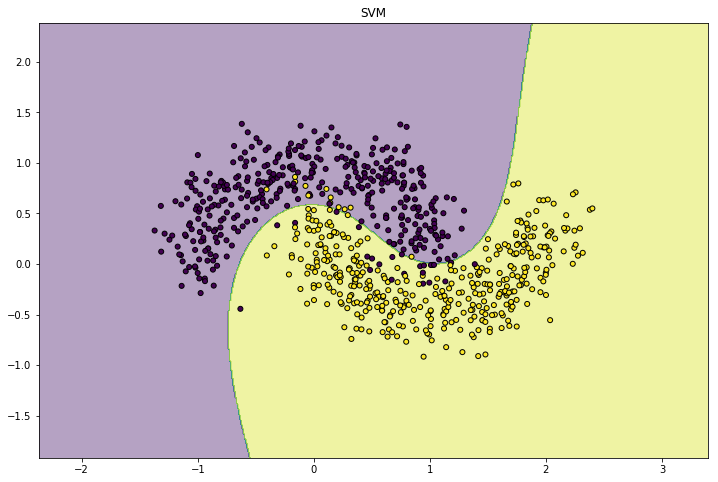

In [1740]:
x_min, x_max = X_2[:, 0].min() - 1, X_2[:, 0].max() + 1
y_min, y_max = X_2[:, 1].min() - 1, X_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
y_score = (cl_rbf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
f, ax1 = plt.subplots(sharex='col', sharey='row', figsize=(12, 8))
ax1.contourf(xx, yy, y_score, alpha=0.4)
ax1.scatter(X_2[:, 0], X_2[:, 1], c=y_2, s=25, edgecolor='k')
ax1.set_title('SVM')
plt.show()

In [1741]:
sol_peg['sol']

(1.0, array([ 0.,  0.,  0., ...,  0.,  0.,  0.]))

In [1742]:
svm = SVMSolver(C=10, method='primal')
svm.fit(X_2, y_2)
print(svm.get_w(), svm.get_w0())

[[ 0.6737174 ]
 [-1.16875587]] -0.03132475034189501


# Эксперименты

## Эксперимент №1

In [1743]:
times_primal = []
cl_primal = SVMSolver(C=1, method='primal')
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X1 = np.random.multivariate_normal(mean = 2 * np.ones(i), cov = np.eye(i), size=500)
    X2 = np.random.multivariate_normal(mean = -2 * np.ones(i), cov = np.eye(i), size=500)
    X = np.vstack((X1, X2))
    y = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0]))))
    start = time.time()
    cl_primal.fit(X, y)
    times_primal.append((time.time() - start, cl_primal.compute_primal_objective(X, y)))

In [1744]:
times_primal

[(0.9866838455200195, 0.011498133417633262),
 (0.9103872776031494, 0.0017086990936257395),
 (0.9731550216674805, 0.00079779728170265311),
 (1.358219861984253, 0.00037774808197092697),
 (1.7197179794311523, 0.00025914726165749346),
 (2.5606629848480225, 0.00019729333252258696),
 (2.5926966667175293, 0.0001553990824343783),
 (3.1811678409576416, 0.00012144718446312964)]

In [1865]:
times_primal_ns = []
cl_primal = SVMSolver(C=1, method='primal')
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
    y[y == 0] = -1
    start = time.time()
    print(X.shape, y.shape)
    cl_primal.fit(X, y, tolerance=1e-7)
    times_primal_ns.append(
        (time.time() - start, cl_primal.compute_primal_objective(X, y)))

(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)


In [1866]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {:.4f} \\\\'.format(elem, times_primal_ns[i][0], times_primal_ns[i][1]))

20 & 6.1076 & 0.6917 \\
100 & 5.2432 & 0.6873 \\
200 & 5.7415 & 0.6627 \\
400 & 5.4869 & 0.6634 \\
600 & 5.1061 & 0.6687 \\
800 & 6.2010 & 0.6679 \\


In [1747]:
times_dual = []
cl_dual = SVMSolver(C=1, method='dual')
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X1 = np.random.multivariate_normal(mean = 2 * np.ones(i), cov = np.eye(i), size=500)
    X2 = np.random.multivariate_normal(mean = -2 * np.ones(i), cov = np.eye(i), size=500)
    X = np.vstack((X1, X2))
    y = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0]))))
    start = time.time()
    cl_dual.fit(X, y)
    times_dual.append((time.time() - start, cl_dual.compute_dual_objective(X, y)))

In [1862]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {:.4f} \\\\'.format(elem, times_dual[i][0], times_dual[i][1]))

20 & 0.9844 & -0.0112 \\
100 & 0.7429 & -0.0017 \\
200 & 0.7953 & -0.0008 \\
400 & 0.6470 & -0.0004 \\
600 & 0.7002 & -0.0002 \\
800 & 0.7042 & -0.0002 \\


In [1863]:
times_dual_ns = []
cl_dual = SVMSolver(C=1, method='dual')
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
    y[y == 0] = -1
    start = time.time()
    print(X.shape, y.shape)
    cl_dual.fit(X, y, tolerance=1e-7)
    times_dual_ns.append(
        (time.time() - start, cl_dual.compute_dual_objective(X, y)))

(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)
(2000, 20) (2000,)


In [1864]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {:.4f} \\\\'.format(elem, times_dual_ns[i][0], times_dual_ns[i][1]))

20 & 5.9114 & -0.5710 \\
100 & 5.5430 & -0.5488 \\
200 & 6.0409 & -0.5823 \\
400 & 5.5996 & -0.6055 \\
600 & 5.8973 & -0.5616 \\
800 & 5.6242 & -0.6133 \\


In [1751]:
times_peg = []
cl_peg = PEGASOSMethod(batch_size=100, step_lambda=0.0001, num_iter=200)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X1 = np.random.multivariate_normal(mean = 2 * np.ones(i), cov = np.eye(i), size=500)
    X2 = np.random.multivariate_normal(mean = -2 * np.ones(i), cov = np.eye(i), size=500)
    X = np.vstack((X1, X2))
    y = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0]))))
    start = time.time()
    sol_peg = cl_peg.fit(X, y)
    times_peg.append((time.time() - start, sol_peg['sol'][0]))

In [1870]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {} \\\\'.format(elem, times_peg[i][0], times_peg[i][1]))

20 & 0.0256 & 0.00031364525205454416 \\
100 & 0.0253 & 1.646210394706731e-07 \\
200 & 0.0279 & 7.697109805051958e-08 \\
400 & 0.0563 & 3.720383855388815e-08 \\
600 & 0.0631 & 2.407319431394525e-08 \\
800 & 0.0817 & 1.7818971219188856e-08 \\


In [1753]:
times_peg_ns = []
cl_peg = PEGASOSMethod(batch_size=100, step_lambda=0.0001, num_iter=2000)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
    y[y == 0] = -1
    start = time.time()
    sol_peg = cl_peg.fit(X, y)
    times_peg_ns.append(
        (time.time() - start, sol_peg['sol'][0]))

In [1872]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {:.4f} \\\\'.format(elem, times_peg_ns[i][0], times_peg_ns[i][1]))

20 & 0.2386 & 0.6596 \\
100 & 0.1819 & 0.6250 \\
200 & 0.1790 & 0.6250 \\
400 & 0.1737 & 0.6250 \\
600 & 0.1729 & 0.6250 \\
800 & 0.1757 & 0.6250 \\


In [1755]:
times_gd = []
cl_gd = GDClassifier(max_iter=2000, step_alpha=0.01, step_beta=0)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X1 = np.random.multivariate_normal(mean = 2 * np.ones(i), cov = np.eye(i), size=500)
    X2 = np.random.multivariate_normal(mean = -2 * np.ones(i), cov = np.eye(i), size=500)
    X = np.vstack((X1, X2))
    y = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0]))))
    start = time.time()
    print(X.shape, y.shape)
    sol_gd = cl_gd.fit(X, y)
    times_gd.append((time.time() - start, sol_gd['sol'][0]))

(1000, 20) (1, 1000)
converged
(1000, 100) (1, 1000)
converged
(1000, 200) (1, 1000)
converged
(1000, 400) (1, 1000)
converged
(1000, 600) (1, 1000)
converged
(1000, 800) (1, 1000)
converged
(1000, 1000) (1, 1000)
converged
(1000, 1200) (1, 1000)
converged


In [1873]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {:.4f} \\\\'.format(elem, times_gd[i][0], times_gd[i][1]))

20 & 0.0145 & 0.0104 \\
100 & 0.0816 & 0.0016 \\
200 & 0.1901 & 0.0008 \\
400 & 0.5748 & 0.0005 \\
600 & 0.9207 & 0.0005 \\
800 & 1.2712 & 0.0005 \\


In [1757]:
times_gd_ns = []
cl_gd = GD = GDClassifier(max_iter=2000, step_alpha=0.01, step_beta=0)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
    y[y == 0] = -1
    print(X.shape, y.shape)
    start = time.time()
    sol_gd = cl_gd.fit(X, y)
    times_gd_ns.append(
        (time.time() - start, sol_gd['sol'][0]))

(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged


In [1874]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {:.4f} \\\\'.format(elem, times_gd_ns[i][0], times_gd_ns[i][1]))

20 & 0.0311 & 0.6644 \\
100 & 0.0227 & 0.6636 \\
200 & 0.0216 & 0.6343 \\
400 & 0.0214 & 0.6744 \\
600 & 0.0183 & 0.6571 \\
800 & 0.0199 & 0.6560 \\


In [1759]:
times_sgd = []
cl_sgd = GD = SGDClassifier(batch_size=100, max_iter=10000, step_alpha=0.01, step_beta=0)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X1 = np.random.multivariate_normal(mean = 2 * np.ones(i), cov = np.eye(i), size=500)
    X2 = np.random.multivariate_normal(mean = -2 * np.ones(i), cov = np.eye(i), size=500)
    X = np.vstack((X1, X2))
    y = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0]))))
    start = time.time()
    print(X.shape, y.shape)
    sol_sgd = cl_sgd.fit(X, y)
    times_sgd.append((time.time() - start, sol_sgd['sol'][0]))

(1000, 20) (1, 1000)
converged
(1000, 100) (1, 1000)
converged
(1000, 200) (1, 1000)
converged
(1000, 400) (1, 1000)
converged
(1000, 600) (1, 1000)
converged
(1000, 800) (1, 1000)
converged
(1000, 1000) (1, 1000)
converged
(1000, 1200) (1, 1000)
converged


In [1875]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {:.4f} \\\\'.format(elem, times_sgd[i][0], times_sgd[i][1]))

20 & 0.0309 & 0.0095 \\
100 & 0.0326 & 0.0016 \\
200 & 0.0472 & 0.0008 \\
400 & 0.1001 & 0.0004 \\
600 & 0.2934 & 0.0002 \\
800 & 0.3057 & 0.0002 \\


In [1761]:
times_sgd_ns = []
cl_sgd = GD = SGDClassifier(batch_size=100, max_iter=10000, step_alpha=0.01, step_beta=0)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
    y[y == 0] = -1
    print(X.shape, y.shape)
    start = time.time()
    sol_sgd = cl_sgd.fit(X, y)
    times_sgd_ns.append(
        (time.time() - start, sol_sgd['sol'][0]))

(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged
(2000, 20) (2000,)
converged


In [1876]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.4f} & {:.4f} \\\\'.format(elem, times_sgd_ns[i][0], times_sgd_ns[i][1]))

20 & 0.0397 & 0.6836 \\
100 & 0.0790 & 0.6558 \\
200 & 0.0592 & 0.6558 \\
400 & 0.0815 & 0.6558 \\
600 & 0.0591 & 0.6558 \\
800 & 0.0608 & 0.6558 \\


## Эксперимент №2

In [1763]:
times_dual_poly = []
cl_dual = SVMSolver(C=1, method='dual', kernel='polynomial', degree=2)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X1 = np.random.multivariate_normal(mean = 2 * np.ones(i), cov = np.eye(i), size=500)
    X2 = np.random.multivariate_normal(mean = -2 * np.ones(i), cov = np.eye(i), size=500)
    X = np.vstack((X1, X2))
    y = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0]))))
    start = time.time()
    cl_dual.fit(X, y)
    times_dual_poly.append((time.time() - start, cl_dual.compute_dual_objective(X, y)))

In [1878]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.5f} & {:.5f} \\\\'.format(elem, times_dual_poly[i][0], times_dual_poly[i][1]))

20 & 0.80425 & -0.00504 \\
100 & 0.63171 & -0.00068 \\
200 & 0.58417 & -0.00031 \\
400 & 0.54843 & -0.00015 \\
600 & 0.54849 & -0.00009 \\
800 & 0.55106 & -0.00006 \\


In [1765]:
times_dual_poly_ns = []
cl_dual = SVMSolver(C=1, method='dual', kernel='polynomial', degree=2)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
    y[y == 0] = -1
    start = time.time()
    #print(X.shape, y.shape)
    cl_dual.fit(X, y, tolerance=1e-7)
    times_dual_poly_ns.append(
        (time.time() - start, cl_dual.compute_dual_objective(X, y)))

In [1880]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.5f} & {:.5f} \\\\'.format(elem, times_dual_poly_ns[i][0], times_dual_poly_ns[i][1]))

20 & 6.59572 & -0.46859 \\
100 & 6.49155 & -0.46181 \\
200 & 7.02777 & -0.45775 \\
400 & 6.56789 & -0.45390 \\
600 & 6.48387 & -0.46021 \\
800 & 6.50691 & -0.45595 \\


In [1767]:
times_dual_poly_moons = []
cl_dual = SVMSolver(C=1, method='dual', kernel='polynomial', degree=3)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_moons(n_samples=1000, shuffle=False, noise=0.05)
    y[y == 0] = -1
    for j in range(1, i // 2):
        X = np.hstack((X, make_moons(n_samples=1000, shuffle=False, noise=0.05)[0]))
    start = time.time()
    #print(X.shape, y.shape)
    cl_dual.fit(X, y, tolerance=1e-7)
    times_dual_poly_moons.append(
        (time.time() - start, cl_dual.compute_dual_objective(X, y)))

In [1883]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.5f} & {:.6f} \\\\'.format(elem, times_dual_poly_moons[i][0], times_dual_poly_moons[i][1]))

20 & 1.32629 & -0.038140 \\
100 & 1.01286 & -0.001444 \\
200 & 1.00395 & -0.000333 \\
400 & 0.94828 & -0.000076 \\
600 & 0.95405 & -0.000031 \\
800 & 0.90380 & 0.000002 \\


In [1903]:
times_dual_rbf = []
cl_dual = SVMSolver(C=100, method='dual', kernel='rbf', gamma=0.001)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X1 = np.random.multivariate_normal(mean = 2 * np.ones(i), cov = np.eye(i), size=500)
    X2 = np.random.multivariate_normal(mean = -2 * np.ones(i), cov = np.eye(i), size=500)
    X = np.vstack((X1, X2))
    y = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0]))))
    start = time.time()
    cl_dual.fit(X, y)
    times_dual_rbf.append((time.time() - start, cl_dual.compute_dual_objective(X, y)))

In [1904]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.5f} & {:.6f} \\\\'.format(elem, times_dual_rbf[i][0], times_dual_rbf[i][1]))

20 & 1.30878 & -5.601870 \\
100 & 1.03489 & -1.715588 \\
200 & 0.91515 & -1.671332 \\
400 & 0.81261 & -2.399846 \\
600 & 0.76469 & -3.620286 \\
800 & 0.78479 & -5.338770 \\


In [1771]:
times_dual_rbf_ns = []
cl_dual = SVMSolver(C=1, method='dual', kernel='rbf', gamma=2.5)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
    y[y == 0] = -1
    start = time.time()
    #print(X.shape, y.shape)
    cl_dual.fit(X, y, tolerance=1e-7)
    times_dual_rbf_ns.append(
        (time.time() - start, cl_dual.compute_dual_objective(X, y)))

In [1772]:
times_dual_rbf_ns

[(5.598034858703613, -0.99974999742283055),
 (5.566427707672119, -0.99974999742283055),
 (5.832911014556885, -0.99974999742283055),
 (6.04909610748291, -0.99974999742283055),
 (5.291949987411499, -0.99974999742283055),
 (5.234868049621582, -0.99974999742283055),
 (5.456310033798218, -0.99974999742283055),
 (5.932142734527588, -0.99974999742283055)]

In [1896]:
times_dual_rbf_moons = []
cl_dual = SVMSolver(C=100, method='dual', kernel='rbf', gamma=0.1)
for i in [20, 100, 200, 400, 600, 800, 1000, 1200]:
    X, y = make_moons(n_samples=1000, shuffle=False, noise=0.05)
    y[y == 0] = -1
    for j in range(1, i // 2):
        X = np.hstack((X, make_moons(n_samples=1000, shuffle=False, noise=0.05)[0]))
    start = time.time()
    #print(X.shape, y.shape)
    cl_dual.fit(X, y, tolerance=1e-7)
    times_dual_rbf_moons.append(
        (time.time() - start, cl_dual.compute_dual_objective(X, y)))

In [1901]:
for i, elem in enumerate([20, 100, 200, 400, 600, 800]):
    print('{:d} & {:.5f} & {:.6f} \\\\'.format(elem, times_dual_rbf_moons[i][0], times_dual_rbf_moons[i][1]))

20 & 1.15386 & -11.499135 \\
100 & 1.05820 & -5.982853 \\
200 & 0.74226 & -7.321465 \\
400 & 0.62636 & -10.674380 \\
600 & 0.63365 & -14.069550 \\
800 & 0.68164 & -17.644177 \\


## Эксперимент №3

In [1775]:
X1 = np.random.multivariate_normal(mean = 2 * np.ones(20), cov = np.eye(20), size=1000)
X2 = np.random.multivariate_normal(mean = -2 * np.ones(20), cov = np.eye(20), size=1000)
X_ls = np.vstack((X1, X2))
y_ls = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0])))).reshape(X_ls.shape[0])

X_moon, y_moon = make_moons(n_samples=2000, shuffle=False, noise=0.05)
y_moon[y_moon == 0] = -1                                 
for j in range(1, 9):
        X_moon = np.hstack((X_moon, make_moons(n_samples=2000, shuffle=False, noise=0.05)[0]))
                                 
X_nb, y_nb = make_classification(n_samples=2000, n_features=20, n_informative=20, n_redundant=0, n_repeated=0, weights=[0.75], flip_y=0.1)
y_nb[y_nb == 0] = -1

In [1776]:
X_ns, y_ns = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
y_ns[y_ns == 0] = -1

In [1777]:
X_train_ls, X_test_ls, y_train_ls, y_test_ls = train_test_split(X_ls, y_ls, train_size=0.7)
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(X_ns, y_ns, train_size=0.7)
X_train_moon, X_test_moon, y_train_moon, y_test_moon = train_test_split(X_moon, y_moon, train_size=0.7)
X_train_nb, X_test_nb, y_train_nb, y_test_nb = train_test_split(X_nb, y_nb, train_size=0.7)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1907]:
cl = SVMSolver(C=1, method='primal')
for k, i in enumerate([(X_train_ls, X_test_ls, y_train_ls, y_test_ls, 'ls'), (X_train_ns, X_test_ns, y_train_ns, y_test_ns, 'ns'), 
          (X_train_moon, X_test_moon, y_train_moon, y_test_moon, 'moons'), (X_train_nb, X_test_nb, y_train_nb, y_test_nb, 'nb')]):
    cl.fit(i[0], i[2])
    y_score = cl.predict(i[1])
    if k == 3:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], roc_auc_score(i[3], y_score), cl.compute_primal_objective(i[0], i[2])))
    else:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], (y_score.reshape(y_score.shape[0]) == i[3]).mean(), cl.compute_primal_objective(i[0], i[2])))

ls & 1.0000 & 0.0112\\
ns & 0.7650 & 0.6978\\
moons & 0.8450 & 0.4446\\
nb & 0.7192 & 0.5789\\


In [1910]:
cl = SVMSolver(C=1, method='dual', kernel='linear')
for k, i in enumerate([(X_train_ls, X_test_ls, y_train_ls, y_test_ls, 'ls'), (X_train_ns, X_test_ns, y_train_ns, y_test_ns, 'ns'), 
          (X_train_moon, X_test_moon, y_train_moon, y_test_moon, 'moons'), (X_train_nb, X_test_nb, y_train_nb, y_test_nb, 'nb')]):
    cl.fit(i[0], i[2])
    y_score = cl.predict(i[1])
    if k == 3:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], roc_auc_score(i[3], y_score), cl.compute_dual_objective(i[0], i[2])))
    else:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], (y_score.reshape(y_score.shape[0]) == i[3]).mean(), cl.compute_dual_objective(i[0], i[2])))

ls & 1.0000 & -0.0112\\
ns & 0.7650 & -0.5938\\
moons & 0.8450 & -0.4445\\
nb & 0.7192 & -0.4631\\


In [1912]:
cl = SVMSolver(C=1, method='dual', kernel='polynomial', degree=3)
for k, i in enumerate([(X_train_ls, X_test_ls, y_train_ls, y_test_ls, 'ls'), (X_train_ns, X_test_ns, y_train_ns, y_test_ns, 'ns'), 
          (X_train_moon, X_test_moon, y_train_moon, y_test_moon, 'moons'), (X_train_nb, X_test_nb, y_train_nb, y_test_nb, 'nb')]):
    cl.fit(i[0], i[2])
    y_score = cl.predict(i[1])
    if k == 3:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], roc_auc_score(i[3], y_score), cl.compute_dual_objective(i[0], i[2])))
    else:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], (y_score.reshape(y_score.shape[0]) == i[3]).mean(), cl.compute_dual_objective(i[0], i[2])))

ls & 1.0000 & -0.0000\\
ns & 0.6500 & -0.0003\\
moons & 1.0000 & -0.0444\\
nb & 0.8015 & -0.0007\\


In [1913]:
cl = SVMSolver(C=100, method='dual', kernel='rbf', gamma=0.1)
for k, i in enumerate([(X_train_ls, X_test_ls, y_train_ls, y_test_ls, 'ls'), (X_train_ns, X_test_ns, y_train_ns, y_test_ns, 'ns'), 
          (X_train_moon, X_test_moon, y_train_moon, y_test_moon, 'moons'), (X_train_nb, X_test_nb, y_train_nb, y_test_nb, 'nb')]):
    cl.fit(i[0], i[2])
    y_score = cl.predict(i[1])
    if k == 3:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], roc_auc_score(i[3], y_score), cl.compute_dual_objective(i[0], i[2])))
    else:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], (y_score.reshape(y_score.shape[0]) == i[3]).mean(), cl.compute_dual_objective(i[0], i[2])))

ls & 1.0000 & -43.7169\\
ns & 0.4767 & -94.5684\\
moons & 1.0000 & -12.5114\\
nb & 0.5000 & -52.9476\\


In [1916]:
cl = PEGASOSMethod(batch_size=100, step_lambda=0.0001, num_iter=200)
for k, i in enumerate([(X_train_ls, X_test_ls, y_train_ls, y_test_ls, 'ls'), (X_train_ns, X_test_ns, y_train_ns, y_test_ns, 'ns'), 
          (X_train_moon, X_test_moon, y_train_moon, y_test_moon, 'moons'), (X_train_nb, X_test_nb, y_train_nb, y_test_nb, 'nb')]):
    sol = cl.fit(i[0], i[2])
    y_score = cl.predict(i[1])
    if k == 3:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], roc_auc_score(i[3], y_score), sol['sol'][0]))
    else:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], (y_score.reshape(y_score.shape[0]) == i[3]).mean(), sol['sol'][0]))

ls & 1.0000 & 0.0001\\
ns & 0.7167 & 0.6471\\
moons & 0.8600 & 0.3086\\
nb & 0.7774 & 0.4079\\


In [1917]:
cl = GDClassifier(max_iter=2000, step_alpha=0.01, step_beta=0)
for k, i in enumerate([(X_train_ls, X_test_ls, y_train_ls, y_test_ls, 'ls'), (X_train_ns, X_test_ns, y_train_ns, y_test_ns, 'ns'), 
          (X_train_moon, X_test_moon, y_train_moon, y_test_moon, 'moons'), (X_train_nb, X_test_nb, y_train_nb, y_test_nb, 'nb')]):
    sol = cl.fit(i[0], i[2])
    y_score = cl.predict(i[1])
    if k == 3:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], roc_auc_score(i[3], y_score), sol['sol'][0]))
    else:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], (y_score.reshape(y_score.shape[0]) == i[3]).mean(), sol['sol'][0]))

converged
ls & 1.0000 & 0.0103\\
converged
ns & 0.7133 & 0.6754\\
converged
moons & 0.8467 & 0.4282\\
converged
nb & 0.7721 & 0.5034\\


In [1918]:
cl = SGDClassifier(batch_size=100, max_iter=10000, step_alpha=0.01, step_beta=0)
for k, i in enumerate([(X_train_ls, X_test_ls, y_train_ls, y_test_ls, 'ls'), (X_train_ns, X_test_ns, y_train_ns, y_test_ns, 'ns'), 
          (X_train_moon, X_test_moon, y_train_moon, y_test_moon, 'moons'), (X_train_nb, X_test_nb, y_train_nb, y_test_nb, 'nb')]):
    sol = cl.fit(i[0], i[2])
    y_score = cl.predict(i[1])
    if k == 3:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], roc_auc_score(i[3], y_score), sol['sol'][0]))
    else:
        print('{} & {:.4f} & {:.4f}\\\\'.format(i[4], (y_score.reshape(y_score.shape[0]) == i[3]).mean(), sol['sol'][0]))

converged
ls & 1.0000 & 0.0096\\
converged
ns & 0.7200 & 0.6768\\
converged
moons & 0.8467 & 0.4269\\
converged
nb & 0.7614 & 0.5039\\


## Эксперимент №4

In [1785]:
X1 = np.random.multivariate_normal(mean = 2 * np.ones(20), cov = np.eye(20), size=1000)
X2 = np.random.multivariate_normal(mean = -2 * np.ones(20), cov = np.eye(20), size=1000)
X_gs_ls = np.vstack((X1, X2))
y_gs_ls = np.hstack((np.ones((1, X1.shape[0])), -np.ones((1, X2.shape[0])))).reshape(X_ls.shape[0])

X_gs_ls_train, X_gs_ls_test, y_gs_ls_train, y_gs_ls_test = train_test_split(X_gs_ls, y_gs_ls, train_size=0.7)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1786]:
X_gs, y_gs = make_moons(n_samples=2000, noise=0.05, shuffle=False)
y_gs[y_gs == 0] = -1

for j in range(1, 10):
    X_gs = np.hstack((X_gs, make_moons(n_samples=2000, shuffle=False, noise=0.05)[0]))
    
X_gs_train, X_gs_test, y_gs_train, y_gs_test = train_test_split(X_gs, y_gs, train_size=0.7)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1787]:
X_ns, y_ns = make_blobs(n_samples=2000, n_features=20, centers=[np.zeros(20), np.ones(20)], cluster_std=3)
y_ns[y_ns == 0] = -1

X_ns_train, X_ns_test, y_ns_train, y_ns_test = train_test_split(X_ns, y_ns, train_size=0.7)

/Users/Artem/anaconda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2010: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [1788]:
def scorer(cl, X_test, y_test):
    y_score = cl.predict(X_test)
    return (y_test == y_score).mean()

In [1789]:
params = {'degree':[1, 2, 3, 4, 5], 'kernel':['polynomial'], 'method':['dual'], 'C':[0.1, 10, 20, 50]}
cl = SVMSolver(C=10, method='dual', kernel='polynomial')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_ls, y_gs_ls)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x1147eb908>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'degree': [1, 2, 3, 4, 5], 'kernel': ['polynomial'], 'method': ['dual'], 'C': [0.1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1790]:
clf.best_score_, clf.best_params_

(1.0, {'C': 0.1, 'degree': 1, 'kernel': 'polynomial', 'method': 'dual'})

In [1791]:
params = {'degree':[2, 3, 4, 5], 'kernel':['polynomial'], 'method':['dual'], 'C':[0.1, 1, 10, 50]}
cl = SVMSolver(C=10, method='dual', kernel='polynomial')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_train, y_gs_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x10aa29b38>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'degree': [2, 3, 4, 5], 'kernel': ['polynomial'], 'method': ['dual'], 'C': [0.1, 1, 10, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1792]:
clf.best_score_, clf.best_params_

(1.0, {'C': 0.1, 'degree': 4, 'kernel': 'polynomial', 'method': 'dual'})

In [1793]:
params = {'degree':[2, 3, 4, 5], 'kernel':['polynomial'], 'method':['dual'], 'C':[0.1, 1, 10, 20, 50]}
cl = SVMSolver(C=10, method='dual', kernel='polynomial')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_ns, y_ns)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x10aa29fd0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'degree': [2, 3, 4, 5], 'kernel': ['polynomial'], 'method': ['dual'], 'C': [0.1, 1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1794]:
clf.best_score_, clf.best_params_

(0.72350000000000003,
 {'C': 20, 'degree': 2, 'kernel': 'polynomial', 'method': 'dual'})

In [1795]:
params = {'gamma':[0.01, 0.05, 0.1, 0.5], 'kernel':['rbf'], 'method':['dual'], 'C':[0.1, 1, 10, 20, 50]}
cl = SVMSolver(C=10, method='dual', kernel='polynomial')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_ls, y_gs_ls)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x10aa29550>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.01, 0.05, 0.1, 0.5], 'kernel': ['rbf'], 'method': ['dual'], 'C': [0.1, 1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1796]:
clf.best_score_, clf.best_params_

(1.0, {'C': 10, 'gamma': 0.01, 'kernel': 'rbf', 'method': 'dual'})

In [1797]:
params = {'gamma':[1, 3, 5, 10], 'kernel':['rbf'], 'method':['dual'], 'C':[0.1, 1, 10, 20, 50]}
cl = SVMSolver(C=10, method='dual', kernel='polynomial')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_train, y_gs_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x111eb5e80>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [1, 3, 5, 10], 'kernel': ['rbf'], 'method': ['dual'], 'C': [0.1, 1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1798]:
clf.best_score_, clf.best_params_

(1.0, {'C': 10, 'gamma': 1, 'kernel': 'rbf', 'method': 'dual'})

In [1799]:
params = {'gamma':[0.0001, 0.001, 0.01], 'kernel':['rbf'], 'method':['dual'], 'C':[100, 500, 1000]}
cl = SVMSolver(C=10, method='dual', kernel='polynomial')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_ns, y_ns)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x11433b518>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'gamma': [0.0001, 0.001, 0.01], 'kernel': ['rbf'], 'method': ['dual'], 'C': [100, 500, 1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1800]:
clf.best_score_, clf.best_params_

(0.78000000000000003,
 {'C': 500, 'gamma': 0.0001, 'kernel': 'rbf', 'method': 'dual'})

In [1801]:
params = {'kernel':['linear'], 'method':['dual'], 'C':[0.1, 1, 10, 20, 50]}
cl = SVMSolver(C=10, method='primal', kernel='linear')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_ls, y_gs_ls)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x10df7bbe0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear'], 'method': ['dual'], 'C': [0.1, 1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1802]:
clf.best_score_, clf.best_params_

(1.0, {'C': 0.1, 'kernel': 'linear', 'method': 'dual'})

In [1803]:
params = {'kernel':['linear'], 'method':['dual'], 'C':[0.1, 1, 10, 20, 50]}
cl = SVMSolver(C=10, method='primal', kernel='linear')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_train, y_gs_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x10aa29898>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear'], 'method': ['dual'], 'C': [0.1, 1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1804]:
clf.best_score_, clf.best_params_

(0.88571428571428568, {'C': 50, 'kernel': 'linear', 'method': 'dual'})

In [1805]:
params = {'kernel':['linear'], 'method':['dual'], 'C':[0.1, 1, 10, 20, 50]}
cl = SVMSolver(C=10, method='primal', kernel='linear')

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_ns, y_ns)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SVMSolver object at 0x10aa29c50>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'kernel': ['linear'], 'method': ['dual'], 'C': [0.1, 1, 10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1806]:
clf.best_score_, clf.best_params_

(0.78149999999999997, {'C': 0.1, 'kernel': 'linear', 'method': 'dual'})

In [1807]:
params = {'step_alpha':[0.01], 'step_beta':[0], 'max_iter':[2000], 'C':[0.1, 1, 10, 20, 50, 100], 'tolerance':[1e-6]}
cl = GDClassifier(step_alpha=0.01, step_beta=0, max_iter=2000, tolerance=1e-6, C=1)

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_ns, y_ns)

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.GDClassifier object at 0x10aa29400>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'step_alpha': [0.01], 'step_beta': [0], 'max_iter': [2000], 'C': [0.1, 1, 10, 20, 50, 100], 'tolerance': [1e-06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1808]:
clf.best_score_, clf.best_params_

(0.71050000000000002,
 {'C': 20,
  'max_iter': 2000,
  'step_alpha': 0.01,
  'step_beta': 0,
  'tolerance': 1e-06})

In [1809]:
params = {'step_alpha':[0.01], 'step_beta':[0], 'max_iter':[2000], 'C':[0.1, 1, 10, 20, 50, 100], 'tolerance':[1e-6]}
cl = GDClassifier(step_alpha=0.01, step_beta=0, max_iter=2000, tolerance=1e-6, C=1)

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_train, y_gs_train)

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.GDClassifier object at 0x10aa29320>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'step_alpha': [0.01], 'step_beta': [0], 'max_iter': [2000], 'C': [0.1, 1, 10, 20, 50, 100], 'tolerance': [1e-06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1810]:
clf.best_score_, clf.best_params_

(0.87714285714285711,
 {'C': 100,
  'max_iter': 2000,
  'step_alpha': 0.01,
  'step_beta': 0,
  'tolerance': 1e-06})

In [1811]:
params = {'batch_size':[100], 'step_alpha':[0.01], 'step_beta':[0], 'max_iter':[10000], 'C':[0.1, 1, 10, 20, 50, 100], 'tolerance':[1e-6]}
cl = SGDClassifier(step_alpha=0.01, step_beta=0, max_iter=2000, tolerance=1e-6, C=1)

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_ns, y_ns)

converged
converged
converged
converged


GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SGDClassifier object at 0x112bfbba8>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'batch_size': [100], 'step_alpha': [0.01], 'step_beta': [0], 'max_iter': [10000], 'C': [0.1, 1, 10, 20, 50, 100], 'tolerance': [1e-06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1812]:
clf.best_score_, clf.best_params_

(0.70899999999999996,
 {'C': 1,
  'batch_size': 100,
  'max_iter': 10000,
  'step_alpha': 0.01,
  'step_beta': 0,
  'tolerance': 1e-06})

In [1813]:
params = {'batch_size':[100], 'step_alpha':[0.01], 'step_beta':[0], 'max_iter':[10000], 'C':[0.1, 1, 10, 20, 50, 100], 'tolerance':[1e-6]}
cl = SGDClassifier(step_alpha=0.01, step_beta=0, max_iter=2000, tolerance=1e-6, C=1)

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_train, y_gs_train)

converged
converged
converged
converged
converged
converged
converged


GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.SGDClassifier object at 0x112bfb9b0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'batch_size': [100], 'step_alpha': [0.01], 'step_beta': [0], 'max_iter': [10000], 'C': [0.1, 1, 10, 20, 50, 100], 'tolerance': [1e-06]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1814]:
clf.best_score_, clf.best_params_

(0.87785714285714289,
 {'C': 100,
  'batch_size': 100,
  'max_iter': 10000,
  'step_alpha': 0.01,
  'step_beta': 0,
  'tolerance': 1e-06})

In [1815]:
params = {'batch_size':[100], 'step_lambda':[0.00001, 0.0001, 0.001, 0.01], 'num_iter':[2000]}
cl = PEGASOSMethod(step_lambda=0.01, batch_size=100, num_iter=2000)

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_ns, y_ns)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.PEGASOSMethod object at 0x112bfb828>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'batch_size': [100], 'step_lambda': [1e-05, 0.0001, 0.001, 0.01], 'num_iter': [2000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1816]:
clf.best_score_, clf.best_params_

(0.70950000000000002,
 {'batch_size': 100, 'num_iter': 2000, 'step_lambda': 1e-05})

In [1817]:
params = {'batch_size':[100], 'step_lambda':[0.00001, 0.0001, 0.001, 0.01], 'num_iter':[1000]}
cl = PEGASOSMethod(step_lambda=0.01, batch_size=100, num_iter=2000)

clf = GridSearchCV(cl, params, scoring=scorer)
clf.fit(X_gs_train, y_gs_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=<__main__.PEGASOSMethod object at 0x112bfb1d0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'batch_size': [100], 'step_lambda': [1e-05, 0.0001, 0.001, 0.01], 'num_iter': [1000]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=<function scorer at 0x114d10f28>, verbose=0)

In [1818]:
clf.best_score_, clf.best_params_

(0.88, {'batch_size': 100, 'num_iter': 1000, 'step_lambda': 0.001})


## Эксперимент №5

In [1920]:
X_gr, y_gr = make_moons(n_samples=2000, noise=0.05, shuffle=False)
y_gr[y_gr == 0] = -1

for j in range(1, 20):
    X_gr = np.hstack((X_gr, make_moons(n_samples=2000, shuffle=False, noise=0.05)[0]))
    
X_gr_1 = np.hstack((np.ones((X_gr.shape[0], 1)), X_gr))

In [1921]:
cl_dual = SVMSolver(method='dual', kernel='linear', C=1)
cl_dual.fit(X_gr, y_gr)

print('weights = ', cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr), 'function value = ', cl_dual.compute_dual_objective(X_gr, y_gr))

weights =  0.0622351140814 [ 0.033509   -0.07576529  0.03207392 -0.07624519  0.03211378 -0.07520117
  0.03136755 -0.0760255   0.03188339 -0.07507137  0.03163326 -0.07635336
  0.03212618 -0.07566406  0.03116113 -0.07685141  0.03198205 -0.07706623
  0.03367452 -0.07618779  0.03200148 -0.07692304  0.03280235 -0.07626599
  0.03258118 -0.07698087  0.03207558 -0.07569829  0.03200145 -0.07625778
  0.03115799 -0.0757579   0.03245364 -0.07681773  0.03298484 -0.07444102
  0.03207099 -0.07661109  0.03306788 -0.07623161] function value =  -0.376379530121


## 1. $\eta = \alpha$

In [1821]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=0.01, step_beta=0, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=0.01, step_beta=0, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.19522619247436523 function value =  0.376588406112
weight difference =  0.0257518726726
converged
gd time =  0.4398181438446045 function value =  0.376442235584
weight difference =  0.00379522373748


In [1822]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=0.1, step_beta=0, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=0.1, step_beta=0, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.03309011459350586 function value =  0.376483820573
weight difference =  0.0129529536773
converged
gd time =  1.44992995262146 function value =  0.376463270188
weight difference =  0.00537432128758


In [1823]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=0.5, step_beta=0, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=0.5, step_beta=0, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start,'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

gd time =  1.8896279335021973 function value =  0.458715674303
weight difference =  0.189595330604
gd time =  3.29113507270813 function value =  0.385339121383
weight difference =  0.203705684274


In [1824]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=1, step_beta=0, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=1, step_beta=0, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

gd time =  1.90339994430542 function value =  1.0
weight difference =  0.373285841082
gd time =  3.318397045135498 function value =  1.0
weight difference =  0.373285841082


## 2. $\eta = \frac{\alpha}{t}$

In [1825]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=1, step_beta=1, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=1, step_beta=1, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.07075810432434082 function value =  0.376606484765
weight difference =  0.0275305457545
converged
gd time =  0.1791849136352539 function value =  0.376457911834
weight difference =  0.00746147657429


In [1826]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=10, step_beta=1, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=10, step_beta=1, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.07578921318054199 function value =  0.37645024855
weight difference =  0.00930217280641
converged
gd time =  0.2335071563720703 function value =  0.376443858198
weight difference =  0.00629806034569


In [1827]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=50, step_beta=1, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=50, step_beta=1, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.2170579433441162 function value =  0.376525422769
weight difference =  0.0060443738245
converged
gd time =  0.4614880084991455 function value =  0.376444042806
weight difference =  0.00221080076904


In [1828]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=200, step_beta=1, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=200, step_beta=1, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.06278014183044434 function value =  1.0
weight difference =  0.373285841082
converged
gd time =  0.6838381290435791 function value =  0.376448955793
weight difference =  0.00271925610888


## 2. $\eta = \frac{\alpha}{t ^ \beta}$

In [1829]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=10, step_beta=1.5, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=10, step_beta=1.5, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.05360221862792969 function value =  0.376528835772
weight difference =  0.019306439952
converged
gd time =  0.12086725234985352 function value =  0.376664924626
weight difference =  0.0328573225075


In [1830]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=100, step_beta=1.5, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=100, step_beta=1.5, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.08385992050170898 function value =  0.376485145287
weight difference =  0.0132594268995
converged
gd time =  0.2474808692932129 function value =  0.376462647018
weight difference =  0.00812406254498


In [1831]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=1000, step_beta=1.5, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=1000, step_beta=1.5, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.21109604835510254 function value =  0.376475887418
weight difference =  0.0112149583611
converged
gd time =  0.489030122756958 function value =  0.37644184092
weight difference =  0.00122162906471


In [1832]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=2000, step_beta=1.5, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=2000, step_beta=1.5, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start, 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
gd time =  0.06422924995422363 function value =  1.0
weight difference =  0.373285841082
converged
gd time =  0.9085931777954102 function value =  0.376962835323
weight difference =  0.0509945799638


## Pegasos

In [1833]:
cl_peg = PEGASOSMethod(batch_size=100, step_lambda=0.0001, num_iter=2000)
start = time.time()
sol = cl_peg.fit(X_gr_1, y_gr)
print('PEGASOS time = ', time.time() - start, 'weights = ', sol['sol'][1], 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

PEGASOS time =  0.22130107879638672 weights =  [ 0.54125528 -0.02252289 -0.1362878  -0.00068935 -0.17963245  0.09384337
 -0.13608888  0.02712923 -0.14845014 -0.02853932 -0.15010007 -0.09919835
 -0.22393784  0.02873049 -0.18955076  0.05070304 -0.15422524  0.00961919
 -0.17952747  0.02439443 -0.16937138 -0.01649028 -0.24380795  0.02763642
 -0.23583547  0.1024325  -0.11223493  0.04352718 -0.2823481   0.15317501
 -0.3279429   0.08409134 -0.20298049  0.12711089 -0.18574596  0.10014827
 -0.07701604  0.09137379 -0.294891    0.05107883 -0.2577677 ] function value =  0.252164915113
weight difference =  0.814870699975


## Эксперимент №6

In [1937]:
batch_size = [1, 5, 10, 20, 30, 40, 50, 60, 70, 100]
times = []
func_val = []
weight_dif = []
for elem in batch_size:
    cl = SGDClassifier(max_iter=10000, batch_size=elem, step_alpha=0.01, step_beta=0, tolerance=1e-6)
    start = time.time()
    sol = cl.fit(X_gr_1, y_gr)
    times.append(time.time() - start)
    func_val.append(sol['sol'][0])
    weight_dif.append(np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

converged
converged
converged


In [1938]:
times, func_val, weight_dif

([0.4286472797393799,
  0.46616077423095703,
  0.4553952217102051,
  0.6380090713500977,
  0.6091251373291016,
  0.5799210071563721,
  0.6136302947998047,
  0.22849726676940918,
  0.2478172779083252,
  0.34023499488830566],
 [0.39173554652654158,
  0.37651132621778249,
  0.37641477064710921,
  0.3764022078493437,
  0.37638409919200466,
  0.3763830858975411,
  0.37638515434120795,
  0.37638857644166074,
  0.37638653874560735,
  0.37638407736870466],
 [0.058927024846627853,
  0.024443840955702602,
  0.0091843770154466584,
  0.0046538816371958043,
  0.0027433071555487513,
  0.0024624422446632727,
  0.0041273392219486138,
  0.0039367600829690068,
  0.0055231614582287713,
  0.0022316592257533184])

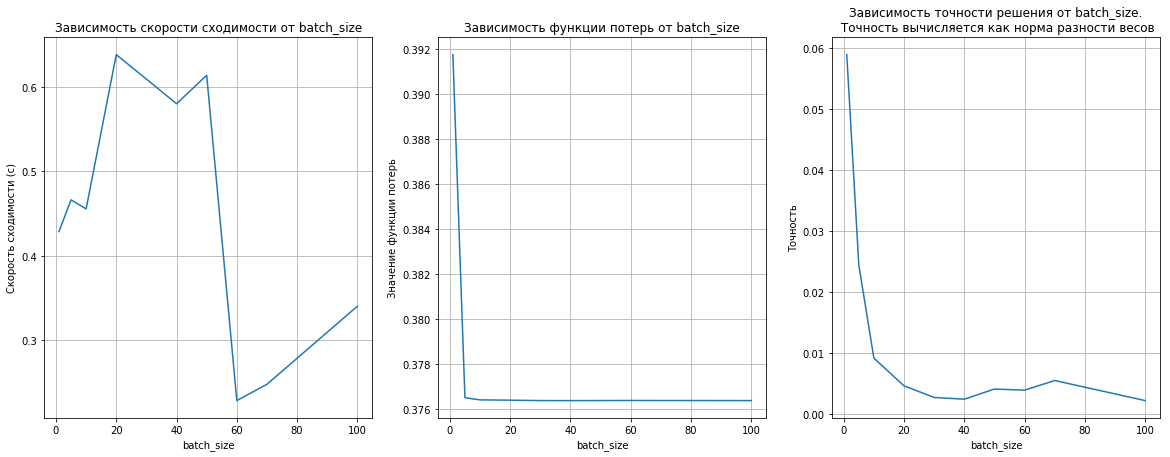

In [1939]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,7))

ax1.plot(batch_size, times)
ax1.set_title(u"Зависимость скорости сходимости от batch_size")
ax1.set_xlabel(u"batch_size")
ax1.set_ylabel(u"Скорость сходимости (с)")
ax1.grid()
ax1.legend()

ax2.plot(batch_size, func_val)
ax2.set_title(u"Зависимость функции потерь от batch_size")
ax2.set_ylabel(u"Значение функции потерь")
ax2.set_xlabel(u"batch_size")
ax2.grid()
ax2.legend()

ax3.plot(batch_size, weight_dif)
ax3.set_title(u"Зависимость точности решения от batch_size.\n Точность вычисляется как норма разности весов")
ax3.set_ylabel(u"Точность")
ax3.set_xlabel(u"batch_size")
ax3.grid()
ax3.legend()
plt.savefig("ex6.pdf", format='pdf', bbox_inches='tight')

## Эксперимент №7

In [1837]:
cl_gd = GDClassifier(loss='logistic', max_iter=4000, step_alpha=0.01, step_beta=0, tolerance=1e-6, C=0.00001)
cl_sgd = SGDClassifier(loss='logistic', batch_size=100, max_iter=20000, step_alpha=0.01, step_beta=0, tolerance=1e-6, C=0.00001)
start = time.time()
sol = cl_gd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start,'weights = ', sol['sol'][1], 'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))
sol = cl_sgd.fit(X_gr_1, y_gr)
print('gd time = ', time.time() - start,'weights = ', sol['sol'][1],  'function value = ', sol['sol'][0])
print('weight difference = ', np.linalg.norm(np.append(cl_dual.get_w0(), cl_dual.get_w(X_gr, y_gr)) - np.array(sol['sol'][1])))

gd time =  0.9816339015960693 weights =  [ 0.72253501  0.04760294 -0.27999577  0.06057302 -0.2865732   0.07325557
 -0.27924657  0.0577645  -0.29008813  0.04811686 -0.28358377  0.03908929
 -0.30493876  0.04769463 -0.29351004  0.06087424 -0.29553427  0.05070976
 -0.29101678  0.05830186 -0.28931027  0.04645552 -0.30417555  0.06039156
 -0.30244248  0.07502304 -0.29295617  0.06109682 -0.30123038  0.08166999
 -0.31559713  0.07629296 -0.30254405  0.07851595 -0.29968142  0.0757053
 -0.27459203  0.06539157 -0.30848394  0.06085698 -0.29874653] function value =  0.23725176657
weight difference =  1.19239334692
converged
gd time =  1.2457997798919678 weights =  [ 0.89307147  0.03726952 -0.28925106  0.06079172 -0.29580787  0.07907773
 -0.28729391  0.05390655 -0.30512438  0.04065422 -0.29410243  0.02371716
 -0.32829626  0.03824234 -0.30960663  0.05820276 -0.31254318  0.04596808
 -0.30792013  0.05348648 -0.30342176  0.03624063 -0.32723542  0.05972328
 -0.32330592  0.08035781 -0.30901402  0.05985499 -

In [1838]:
X_gr_ns, y_gr_ns = make_classification(n_samples=700, n_features=20, n_informative=20, n_redundant=0, n_repeated=0, weights=[0.75], flip_y=0.2, random_state=2341)
y_gr_ns[y_gr_ns == 0] = -1
X_gr_ns = np.hstack((np.ones((X_gr_ns.shape[0], 1)), X_gr_ns))

In [1839]:
cl_gd = GDClassifier(loss='logistic', max_iter=4000, step_alpha=0.01, step_beta=0, tolerance=1e-6, C=0.00001)
cl_sgd = SGDClassifier(loss='logistic', batch_size=100, max_iter=20000, step_alpha=0.01, step_beta=0, tolerance=1e-6, C=0.00001)
start = time.time()
sol = cl_gd.fit(X_gr_ns, y_gr_ns)
print('gd time = ', time.time() - start,'weights = ', sol['sol'][1], 'function value = ', sol['sol'][0])
print('accuracy = ', cross_val_score(cl_gd, X_gr_ns, y_gr_ns, cv=4, scoring='accuracy').mean())
sol = cl_sgd.fit(X_gr_ns, y_gr_ns)
print('gd time = ', time.time() - start,'weights = ', sol['sol'][1],  'function value = ', sol['sol'][0])
print('accuracy = ', cross_val_score(cl_sgd, X_gr_ns, y_gr_ns, cv=4, scoring='accuracy').mean())

converged
gd time =  0.27046704292297363 weights =  [-0.42476175  0.01937054 -0.06616374 -0.01990139  0.02325637 -0.08759979
  0.18065836 -0.13764903 -0.02547718  0.08598983 -0.19537489  0.05869523
 -0.12485796 -0.10218275 -0.07811928 -0.10844815  0.00055921 -0.08269934
  0.10821573 -0.18309568  0.0823305 ] function value =  0.456270006553
converged
converged
converged
converged
accuracy =  0.787142857143
converged
gd time =  0.35845088958740234 weights =  [-0.37885438  0.02106535 -0.06384185 -0.01876697  0.02151351 -0.08491278
  0.18407976 -0.12974416 -0.03770527  0.10126657 -0.21288924  0.06487725
 -0.13510628 -0.11712758 -0.07323055 -0.11047002  0.00292632 -0.07743039
  0.10274305 -0.18392315  0.08035109] function value =  0.45725579123
converged
converged
converged
converged
accuracy =  0.78


In [1840]:
cl_gd = GDClassifier(max_iter=4000, step_alpha=0.01, step_beta=0, tolerance=1e-6)
cl_sgd = SGDClassifier(batch_size=100, max_iter=20000, step_alpha=0.01, step_beta=0, tolerance=1e-6)
start = time.time()
sol = cl_gd.fit(X_gr_ns, y_gr_ns)
print('gd time = ', time.time() - start,'weights = ', sol['sol'][1], 'function value = ', sol['sol'][0])
print('accuracy = ', cross_val_score(cl_gd, X_gr_ns, y_gr_ns, cv=4, scoring='accuracy').mean())
sol = cl_sgd.fit(X_gr_ns, y_gr_ns)
print('gd time = ', time.time() - start,'weights = ', sol['sol'][1],  'function value = ', sol['sol'][0])
print('accuracy = ', cross_val_score(cl_sgd, X_gr_ns, y_gr_ns, cv=4, scoring='accuracy').mean())

converged
gd time =  0.14189505577087402 weights =  [-0.41577143  0.02649367 -0.03586364  0.00916618  0.0258846  -0.07592448
  0.0874813  -0.03863514 -0.02110454  0.05541993 -0.11488321  0.03085955
 -0.09981481 -0.0472906  -0.01801388 -0.05052812  0.01992112 -0.03905639
  0.04381367 -0.11176454  0.03680419] function value =  0.51386504468
converged
converged
converged
converged
accuracy =  0.808571428571
converged
gd time =  1.1703519821166992 weights =  [-0.496       0.01822001 -0.03385612  0.00216859  0.02820522 -0.07599233
  0.0762983  -0.04304513 -0.02427291  0.06637497 -0.10800456  0.01983765
 -0.08612397 -0.04900269 -0.02672199 -0.04125316  0.02511678 -0.04330865
  0.03917452 -0.10657134  0.03725199] function value =  0.513540299005
converged
converged
converged
accuracy =  0.807142857143


In [1841]:
cl_peg = PEGASOSMethod(batch_size=100, step_lambda=0.0001, num_iter=2000)
start = time.time()
sol = cl_peg.fit(X_gr_ns, y_gr_ns)
print('PEGASOS time = ', time.time() - start, 'weights = ', sol['sol'][1], 'function value = ', sol['sol'][0])
print('accuracy = ', cross_val_score(cl_peg, X_gr_ns, y_gr_ns, cv=4, scoring='accuracy').mean())

PEGASOS time =  0.1829540729522705 weights =  [ -3.54878550e-01   2.41495397e-03  -2.95298441e-02   3.78753631e-02
   4.36542931e-02  -1.26447523e-01   1.39720377e-01  -9.06641734e-02
  -4.31633523e-02   5.92829190e-02  -1.61040322e-01   3.71303208e-02
  -1.35538578e-01  -6.14692843e-02  -2.53115622e-02  -4.21058719e-02
   3.06289521e-04  -1.14305204e-01   7.88846196e-02  -1.21770012e-01
   8.07101952e-02] function value =  0.472368180218
accuracy =  0.814285714286


## Эксперимент №8

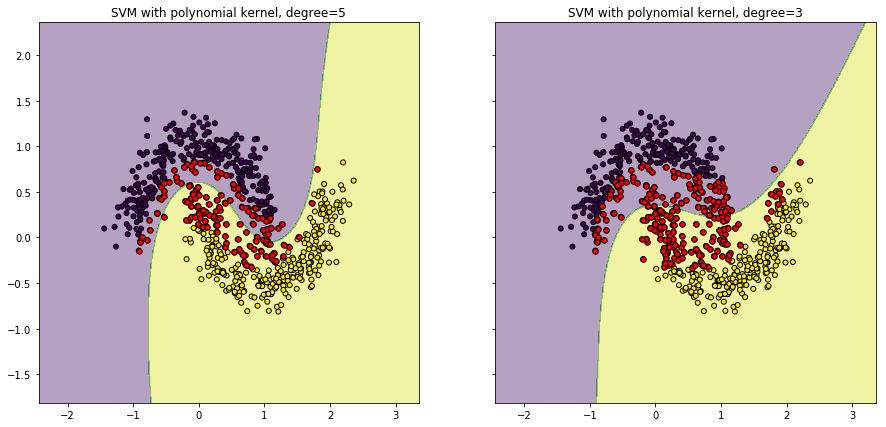

In [1941]:
X_2, y_2 = make_moons(n_samples=700, noise=0.15, random_state=12344)
y_2[y_2 == 0] = -1

cl_poly_5 = SVMSolver(C=10, method='dual', kernel='polynomial', degree=5)
cl_poly_5.fit(X_2, y_2)

cl_poly_3 = SVMSolver(C=10, method='dual', kernel='polynomial', degree=3)
cl_poly_3.fit(X_2, y_2)

x_min, x_max = X_2[:, 0].min() - 1, X_2[:, 0].max() + 1
y_min, y_max = X_2[:, 1].min() - 1, X_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
y_score_poly_5 = (cl_poly_5.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
y_score_poly_3 = (cl_poly_3.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
f, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(15, 7))
ax1.contourf(xx, yy, y_score_poly_5, alpha=0.4)
ax1.scatter(X_2[:, 0], X_2[:, 1], c=y_2, s=25, edgecolor='k')
ax1.scatter(cl_poly_5.sv[:, 0], cl_poly_5.sv[:, 1], c='red', s=30, edgecolor='k')
ax1.set_title('SVM with polynomial kernel, degree=5')
ax2.contourf(xx, yy, y_score_poly_3, alpha=0.4)
ax2.scatter(X_2[:, 0], X_2[:, 1], c=y_2, s=25, edgecolor='k')
ax2.scatter(cl_poly_3.sv[:, 0], cl_poly_3.sv[:, 1], c='red', s=30, edgecolor='k')
ax2.set_title('SVM with polynomial kernel, degree=3')

plt.savefig("poly.pdf", format='pdf', bbox_inches='tight')

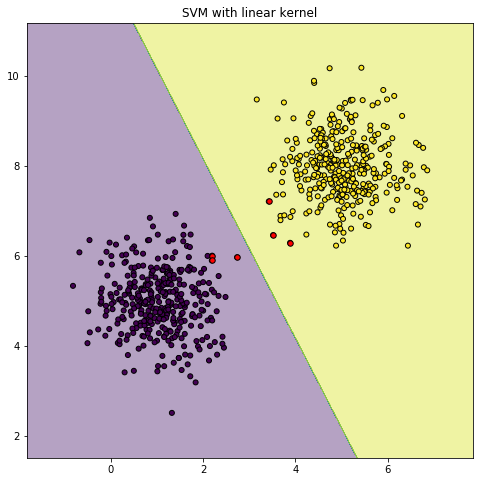

In [1942]:
X, y = make_blobs(n_samples=700, centers=[[1.0, 5.0], [5.0, 8.0]], cluster_std=0.7, random_state=1234)
y[y == 0] = -1

X_1, y_1 = make_blobs(n_samples=700, centers=[[0, 0], [1, 1]], cluster_std=1, random_state=2341)
y_1[y_1 == 0] = -1

X_3, y_3 = make_classification(n_samples=700, n_features=2, n_informative=2, n_redundant=0, n_repeated=0, weights=[0.75], flip_y=0.1, random_state=2341)
y_3[y_3 == 0] = -1

cl_lin = SVMSolver(C=300, method='dual', kernel='linear')

f, (ax) = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))

cl_lin.fit(X, y)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
y_score_1 = (cl_lin.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contourf(xx, yy, y_score_1, alpha=0.4)
ax.scatter(X[:, 0], X[:, 1], c=y, s=25, edgecolor='k')
ax.scatter(cl_lin.sv[:, 0], cl_lin.sv[:, 1], c='red', s=30, edgecolor='k')
ax.set_title('SVM with linear kernel')


plt.savefig("ls_lin.pdf", format='pdf', bbox_inches='tight')

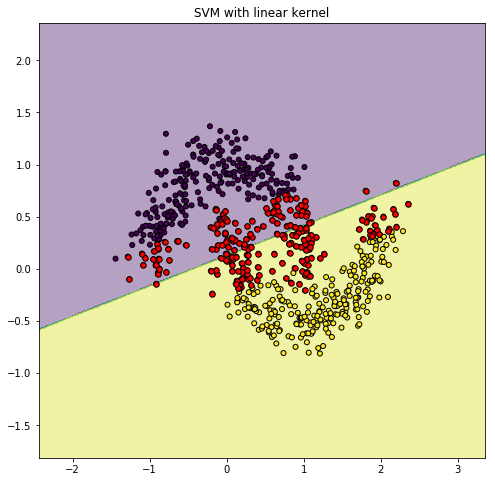

In [1943]:
f, (ax) = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))

cl_lin.fit(X_2, y_2)
x_min, x_max = X_2[:, 0].min() - 1, X_2[:, 0].max() + 1
y_min, y_max = X_2[:, 1].min() - 1, X_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
y_score_2 = (cl_lin.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contourf(xx, yy, y_score_2, alpha=0.4)
ax.scatter(X_2[:, 0], X_2[:, 1], c=y_2, s=25, edgecolor='k')
ax.scatter(cl_lin.sv[:, 0], cl_lin.sv[:, 1], c='red', s=30, edgecolor='k')
ax.set_title('SVM with linear kernel')

plt.savefig("moons_lin.pdf", format='pdf', bbox_inches='tight')

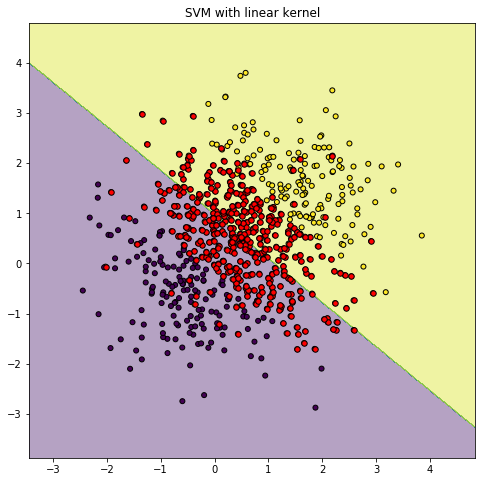

In [1944]:
f, (ax) = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))

cl_lin.fit(X_1, y_1)
x_min, x_max = X_1[:, 0].min() - 1, X_1[:, 0].max() + 1
y_min, y_max = X_1[:, 1].min() - 1, X_1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
y_score_3 = (cl_lin.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contourf(xx, yy, y_score_3, alpha=0.4)
ax.scatter(X_1[:, 0], X_1[:, 1], c=y_1, s=25, edgecolor='k')
ax.scatter(cl_lin.sv[:, 0], cl_lin.sv[:, 1], c='red', s=30, edgecolor='k')
ax.set_title('SVM with linear kernel')

plt.savefig("ns_lin.pdf", format='pdf', bbox_inches='tight')

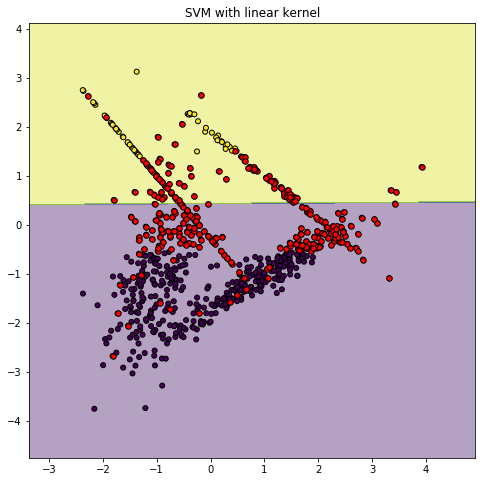

In [1945]:
f, (ax) = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))

cl_lin.fit(X_3, y_3)
x_min, x_max = X_3[:, 0].min() - 1, X_3[:, 0].max() + 1
y_min, y_max = X_3[:, 1].min() - 1, X_3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
y_score_4 = (cl_lin.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contourf(xx, yy, y_score_4, alpha=0.4)
ax.scatter(X_3[:, 0], X_3[:, 1], c=y_3, s=25, edgecolor='k')
ax.scatter(cl_lin.sv[:, 0], cl_lin.sv[:, 1], c='red', s=30, edgecolor='k')
ax.set_title('SVM with linear kernel')

plt.savefig("nb_lin.pdf", format='pdf', bbox_inches='tight')

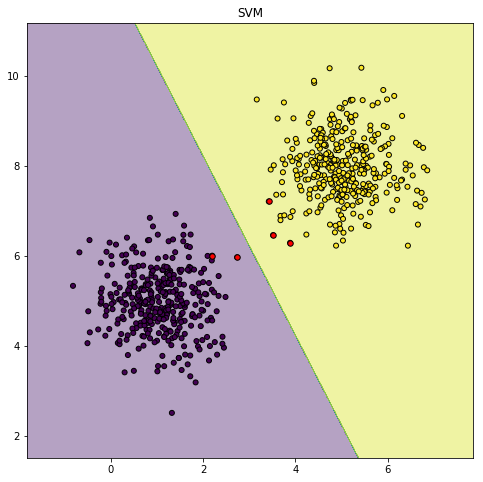

In [1847]:
from sklearn.svm import SVC

svm = SVC(kernel='linear')
svm.fit(X, y)


x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
y_score = (svm.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
f, ax1 = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))
ax1.contourf(xx, yy, y_score, alpha=0.4)
ax1.scatter(X[:, 0], X[:, 1], c=y, s=25, edgecolor='k')
ax1.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], c='red', s=30, edgecolor='k')
ax1.set_title('SVM')
plt.show()

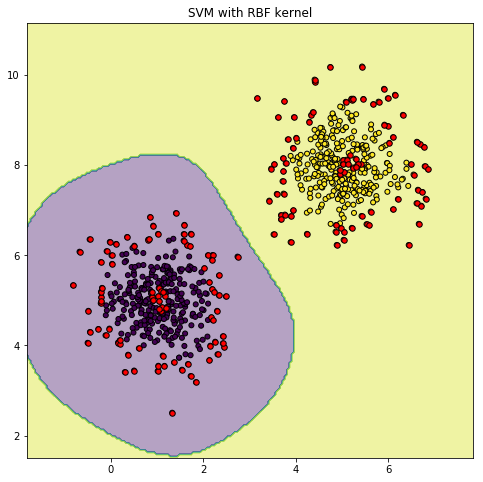

In [1950]:
cl_rbf = SVMSolver(C=50, method='dual', kernel='rbf', gamma=1)

f, (ax) = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))

cl_rbf.fit(X, y)
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
y_score_1 = (cl_rbf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contourf(xx, yy, y_score_1, alpha=0.4)
ax.scatter(X[:, 0], X[:, 1], c=y, s=25, edgecolor='k')
ax.scatter(cl_rbf.sv[:, 0], cl_rbf.sv[:, 1], c='red', s=30, edgecolor='k')
ax.set_title('SVM with RBF kernel')


plt.savefig("ls_rbf.pdf", format='pdf', bbox_inches='tight')

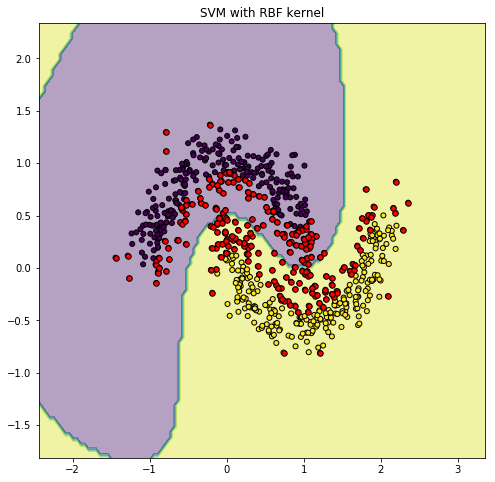

In [1951]:
f, (ax) = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))

cl_rbf = SVMSolver(C=50, method='dual', kernel='rbf', gamma=1.5)
cl_rbf.fit(X_2, y_2)
x_min, x_max = X_2[:, 0].min() - 1, X_2[:, 0].max() + 1
y_min, y_max = X_2[:, 1].min() - 1, X_2[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
y_score_2 = (cl_rbf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contourf(xx, yy, y_score_2, alpha=0.4)
ax.scatter(X_2[:, 0], X_2[:, 1], c=y_2, s=25, edgecolor='k')
ax.scatter(cl_rbf.sv[:, 0], cl_rbf.sv[:, 1], c='red', s=30, edgecolor='k')
ax.set_title('SVM with RBF kernel')

plt.savefig("moons_rbf.pdf", format='pdf', bbox_inches='tight')

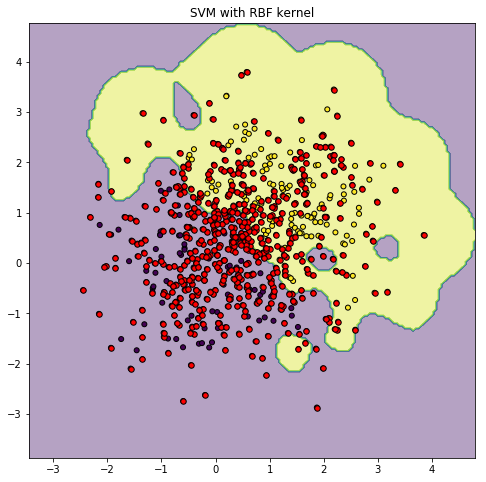

In [1952]:
f, (ax) = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))

cl_rbf = SVMSolver(C=1500, method='dual', kernel='rbf', gamma=5)
cl_rbf.fit(X_1, y_1)
x_min, x_max = X_1[:, 0].min() - 1, X_1[:, 0].max() + 1
y_min, y_max = X_1[:, 1].min() - 1, X_1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
y_score_3 = (cl_rbf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contourf(xx, yy, y_score_3, alpha=0.4)
ax.scatter(X_1[:, 0], X_1[:, 1], c=y_1, s=25, edgecolor='k')
ax.scatter(cl_rbf.sv[:, 0], cl_rbf.sv[:, 1], c='red', s=30, edgecolor='k')
ax.set_title('SVM with RBF kernel')

plt.savefig("ns_rbf.pdf", format='pdf', bbox_inches='tight')

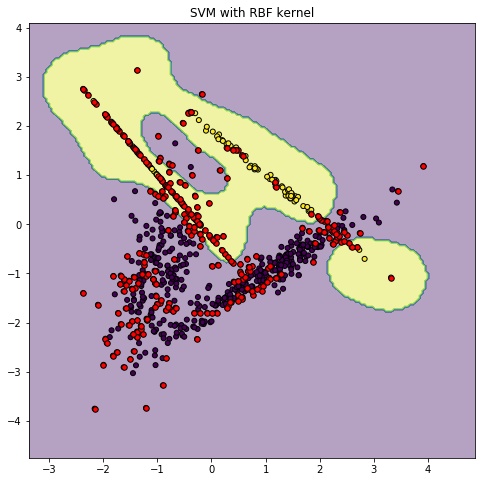

In [1953]:
f, (ax) = plt.subplots(sharex='col', sharey='row', figsize=(8, 8))

cl_rbf = SVMSolver(C=1500, method='dual', kernel='rbf', gamma=2.5)
cl_rbf.fit(X_3, y_3)
x_min, x_max = X_3[:, 0].min() - 1, X_3[:, 0].max() + 1
y_min, y_max = X_3[:, 1].min() - 1, X_3[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))
y_score_4 = (cl_rbf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax.contourf(xx, yy, y_score_4, alpha=0.4)
ax.scatter(X_3[:, 0], X_3[:, 1], c=y_3, s=25, edgecolor='k')
ax.scatter(cl_rbf.sv[:, 0], cl_rbf.sv[:, 1], c='red', s=30, edgecolor='k')
ax.set_title('SVM with RBF kernel')

plt.savefig("nb_rbf.pdf", format='pdf', bbox_inches='tight')

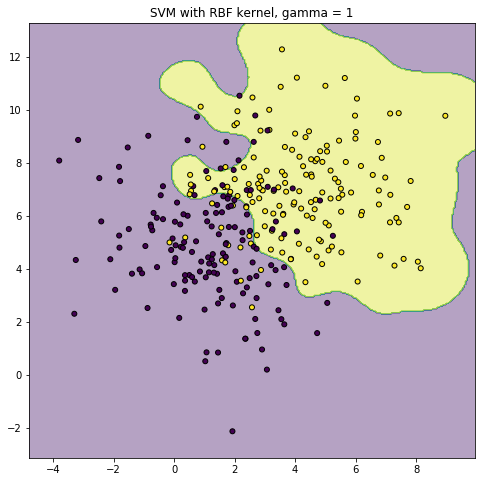

In [1960]:
cl_st = StandardScaler()
X_last, y_last = make_blobs(n_samples=300, centers=[[1.0, 5.0], [4.0, 7.0]], cluster_std=2, random_state=1234)
y_last[y_last == 0] = -1

f, (ax1) = plt.subplots(1, sharex='col', sharey='row', figsize=(8, 8))

x_min, x_max = X_last[:, 0].min() - 1, X_last[:, 0].max() + 1
y_min, y_max = X_last[:, 1].min() - 1, X_last[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.05), np.arange(y_min, y_max, 0.05))

cl_rbf = SVMSolver(C=1000, method='dual', kernel='rbf', gamma=1)
cl_rbf.fit(X_last, y_last)
y_score_last = (cl_rbf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax1.contourf(xx, yy, y_score_last, alpha=0.4)
ax1.scatter(X_last[:, 0], X_last[:, 1], c=y_last, s=25, edgecolor='k')
#ax1.scatter(cl_rbf.sv[:, 0], cl_rbf.sv[:, 1], c='red', s=30, edgecolor='k')
ax1.set_title('SVM with RBF kernel, gamma = 1')

plt.savefig("rbf1.pdf", format='pdf', bbox_inches='tight')

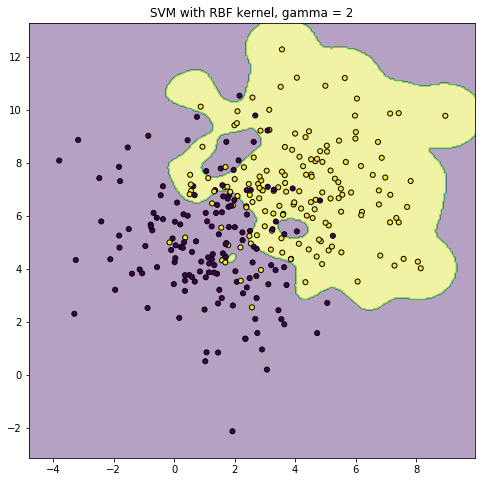

In [1961]:
f, (ax1) = plt.subplots(1, sharex='col', sharey='row', figsize=(8, 8))
cl_rbf = SVMSolver(C=1000, method='dual', kernel='rbf', gamma=2)
cl_rbf.fit(X_last, y_last)
y_score_last = (cl_rbf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax1.contourf(xx, yy, y_score_last, alpha=0.4)
ax1.scatter(X_last[:, 0], X_last[:, 1], c=y_last, s=25, edgecolor='k')
#ax2.scatter(cl_rbf.sv[:, 0], cl_rbf.sv[:, 1], c='red', s=30, edgecolor='k')
ax1.set_title('SVM with RBF kernel, gamma = 2')

plt.savefig("rbf2.pdf", format='pdf', bbox_inches='tight')


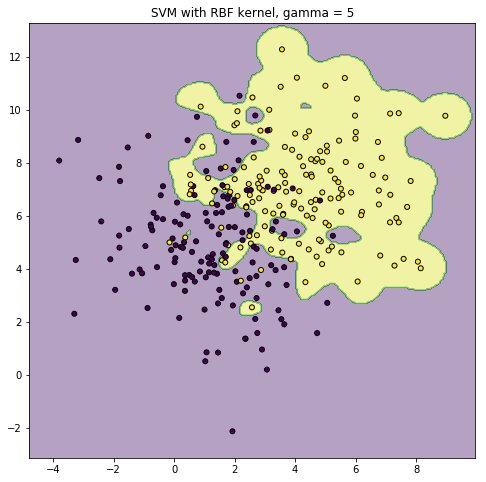

In [1962]:
f, (ax1) = plt.subplots(1, sharex='col', sharey='row', figsize=(8, 8))
cl_rbf = SVMSolver(C=1000, method='dual', kernel='rbf', gamma=5)
cl_rbf.fit(X_last, y_last)
y_score_last = (cl_rbf.predict(np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
ax1.contourf(xx, yy, y_score_last, alpha=0.4)
ax1.scatter(X_last[:, 0], X_last[:, 1], c=y_last, s=25, edgecolor='k')
#ax3.scatter(cl_rbf.sv[:, 0], cl_rbf.sv[:, 1], c='red', s=30, edgecolor='k')
ax1.set_title('SVM with RBF kernel, gamma = 5')

plt.savefig("rbf3.pdf", format='pdf', bbox_inches='tight')